# Neural Style Transfer

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/Deep_Learning_Specialization/portfolio-7.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

**Objective**: Implement a Neural Style Transfer model to generate novel artistic images.

[Neural Style Transfer (NST)](https://en.wikipedia.org/wiki/Neural_style_transfer) is one of the most fun and interesting optimization techniques in deep learning. It merges two images, namely: a "content" image (C-image) and a "style" image (S-image), to create a "generated" image (G-image). The G-image combines the "content" of the C-image with the "style" of S-image.

## Import libraries

In [1]:
from keras import applications, optimizers, Model
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tensorflow as tf
import numpy as np
from IPython.display import HTML
from tqdm import tqdm

2025-01-04 12:31:37.502309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736015497.525648  114877 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736015497.532420  114877 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 12:31:37.555683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the content image and style image

In [ ]:
%%bash

wget -nc --progress=bar:force:noscroll https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg -O /tmp/C-image.jpg
wget -nc --progress=bar:force:noscroll https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg -O /tmp/S-image.jpg

## Visualize the images 

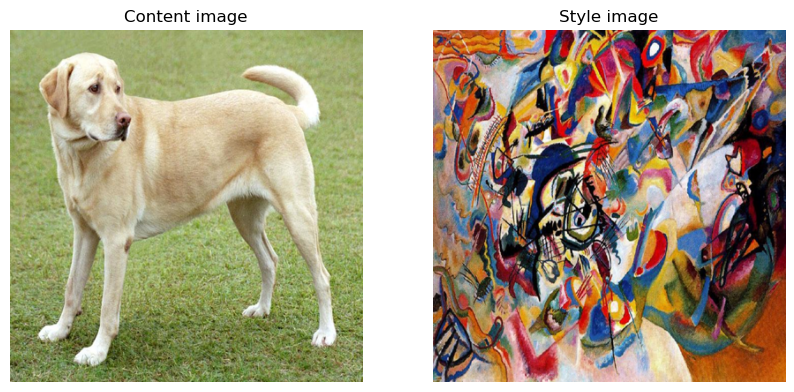

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 15))

content_image = Image.open("/tmp/C-image.jpg").resize((400, 400))
style_image = Image.open("/tmp/S-image.jpg").resize((400, 400))

axs[0].imshow(content_image)
axs[0].axis("off")
axs[0].set_title("Content image")

axs[1].imshow(style_image)
axs[1].axis("off")
axs[1].set_title("Style image")

plt.show()

## Load a pretrained VGG19 model

We'll use transfer learning to load a pretrained convolutional neural network and build on top of it. We'll use the [Visual Geometry Group (VGG)](https://arxiv.org/abs/1508.06576) network, specifically the VGG19, which is a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database and has learned to recognize a variety of low-level features such as edges and simple textures (in the shallower layers) and high-level features such as more complex textures and object classes (in the deeper layers).

In [4]:
%%bash

if [ -e "/tmp/vgg19_weights_no-top.h5.gz" ]; then
    echo "vgg19_weights_no-top.h5.gz already exists!"
else
    gdown 1ysYUNOHkg0NmITtBefG1vzjMbUyzP_ta -O /tmp/
fi

gunzip -kf /tmp/vgg19_weights_no-top.h5.gz

vgg19_weights_no-top.h5.gz already exists!


In [5]:
model = applications.VGG19(include_top=False, input_shape=(400, 400, 3), weights='/tmp/vgg19_weights_no-top.h5')
model.trainable = False
model.summary()

I0000 00:00:1736015502.052163  114877 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1707 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 400, 400, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 400, 400, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 200, 200, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 100, 100, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 50, 50, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

## Compute costs

### Content cost

One goal to achieve when performing NST is that the content of the G-image matches the content of the C-image. One method to achieve this is to calculate the content cost function.

In [6]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- Tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- Tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- Scalar content cost
    """

    a_C = content_output[-1]
    a_G = generated_output[-1]

    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.shape

    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]), perm=[0, 2, 1])
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]), perm=[0, 2, 1])

    # Compute the cost
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content

### Style cost

The goal is to minimize the distance between the style matrix (also known as [Gram matrix](https://en.wikipedia.org/wiki/Gram_matrix)) of the S-image and the style matrix of the G-image.

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- Matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A, A, transpose_b=True)

    return GA

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- Tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- Tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- Tensor representing a scalar value, style cost
    """

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.shape

    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = tf.reduce_sum((GS - GG)**2) / (2 * n_C * n_H * n_W)**2

    return J_style_layer

We'll get better results if we "merge" style costs from several different layers. We'll choose layers to represent the style of the image and assign style costs. Each layer will be given weights that reflect how much each layer will contribute to the style.

**How to choose the coefficients for each layer?**

Deeper layers capture higher-level concepts and features in deeper layers are less localized in the image relative to each other. Therefore,  if we want the generated image to smoothly follow the S-image, try choosing larger weights for deeper layers and smaller weights for the earlier layers. On the contrary, if we want the G-image to strongly follow the S-image, try choosing smaller weights for deeper layers and larger weights for earlier layers.

In [8]:
STYLE_LAYERS = [('block1_conv1', 0.3),
                ('block2_conv1', 0.25),
                ('block3_conv1', 0.2),
                ('block4_conv1', 0.15),
                ('block5_conv1', 0.1)]

In [9]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- 
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - The names of the layers we would like to extract style from
                        - A coefficient for each of them

    Returns:
    J_style -- Tensor representing a scalar value, style cost
    """

    # Initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The first element of the array contains the input layer image, which must not to be used.
    a_S = style_image_output[1:]

    # Set a_G to be the output of the choosen hidden layers.
    # The First element of the list contains the input layer image which must not to be used.
    a_G = generated_image_output[1:]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

### Total cost

In [10]:
@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function

    Arguments:
    J_content -- Content cost
    J_style -- Style cost
    alpha -- Hyperparameter weighting the importance of the content cost
    beta -- Hyperparameter weighting the importance of the style cost

    Returns:
    J -- Total cost
    """

    J = alpha * J_content + beta * J_style

    return J

## Compile and train the model

In [11]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""

    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = Model([vgg.input], outputs)

    return model

Initializing the pixels of the G-image to be mostly noise but loosely correlated with the content image will help the content of the G-image to match the content of the C-image more quickly.

In [12]:
content_image = tf.image.convert_image_dtype(np.array([content_image]), tf.float32)
style_image = tf.image.convert_image_dtype(np.array([style_image]), tf.float32)

noise = tf.random.uniform(tf.shape(content_image), 0, 0.1)
generated_image = tf.add(content_image, noise)
generated_image = tf.Variable(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

Assign the C-image and the S-image to be the input of the VGG19 model.

In [13]:
content_layer = [('block5_conv4', 1)]
model_outputs = get_layer_outputs(model, STYLE_LAYERS + content_layer)

a_S = model_outputs(style_image)
a_C = model_outputs(content_image)

/home/luis-mendoza/miniconda3/envs/portfolio/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)
I0000 00:00:1736015504.125355  114877 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-04 12:31:44.806939: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12:31:45.025263: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-

In [14]:
optimizer = optimizers.Adam()

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Compute a_G as the model_outputs for the current generated image
        a_G = model_outputs(generated_image)

        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style, 10, 40)

    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

    return J

## Evaluate the model

In [15]:
epochs = 10000
frames = []

fig, ax = plt.subplots()

for i in tqdm(range(1, epochs+1)):
    train_step(generated_image)

    if i % (epochs/10) == 0 or i == 1:
        plt.tight_layout()
        ax.axis("off")
        text = ax.text(0, -10, "Epoch = {}".format(i), fontdict={"fontsize": "large"}, animated=True)
        frame = ax.imshow(generated_image[0], animated=True)
        frames.append([frame, text])
    
anim = animation.ArtistAnimation(fig, frames, blit=True, repeat_delay=1000)
plt.close(fig)

HTML(anim.to_html5_video())

  0%|          | 0/10000 [00:00<?, ?it/s]2025-01-04 12:31:48.913851: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12:31:48.993030: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12:31:49.223248: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-04 12: